In [1]:
# Disable Multithreading for analysis
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['VECLIB_MAXIMUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'

import cr_autophagy as cra
from pathlib import Path

import importlib
importlib.reload(cra)
import glob
import numpy as np
import multiprocessing as mp
import tqdm
import matplotlib.pyplot as plt
import seaborn as sb

discretization_factor = 0.5
bw_method = 0.2
threshold = 0.3

def gather_result(output_path):
    # Obtain settings of simulation
    simulation_settings = cra.get_simulation_settings(output_path)

    # Currently we are only gathering information from the last iteration
    max_iter = np.max(cra.get_all_iterations(output_path))

    # Compute the kernel-density clusters
    kde_clrs = cra.get_clusters_kde(
        output_path,
        max_iter,
        threshold=threshold,
        discretization_factor=discretization_factor,
        bw_method=bw_method
    )
    if kde_clrs != None and kde_clrs.validate():
        kde_clusters = kde_clrs.n_clusters
        kde_clusters_at_cargo = len(kde_clrs.clusters_at_cargo(relative_radial_distance=0.5))
    else:
        kde_clusters = np.nan
        kde_clusters_at_cargo = np.nan
    
    # Compute the graph clusters
    graph_clrs = cra.get_clusters_graph(output_path, max_iter)
    if graph_clrs != None and graph_clrs.validate():
        graph_clusters = graph_clrs.n_clusters
        graph_clusters_at_cargo = len(graph_clrs.clusters_at_cargo(relative_radial_distance=0.5))
    else:
        graph_clusters = np.nan
        graph_clusters_at_cargo = np.nan

    # Return all results in a dictionary
    return {
        "kde_clusters": kde_clusters,
        "kde_clusters_at_cargo": kde_clusters_at_cargo,
        "graph_clusters": graph_clusters,
        "graph_clusters_at_cargo": graph_clusters_at_cargo,
        "potential_strength_r11_r11": simulation_settings.potential_strength_r11_r11,
        "potential_strength_cargo_r11": simulation_settings.potential_strength_cargo_r11,
        "potential_strength_cargo_r11_avidity": simulation_settings.potential_strength_cargo_r11_avidity,
        "kb_temperature_r11": simulation_settings.kb_temperature_r11,
        "interaction_relative_neighbour_distance": simulation_settings.interaction_relative_neighbour_distance,
        "iteration": max_iter,
        "output_path": output_path,
    }

In [ ]:
# UNCOMMENT THESE LINES TO GENERATE THE PARAMETER SPACE OUTPUT FILE
# args = [Path(folder) for folder in glob.glob("out/autophagy/explore_parameter_space_2_*")]
# pool = mp.Pool(40)
# results = cra.pd.DataFrame(list(tqdm.tqdm(pool.imap_unordered(gather_result, args), total=len(args))))
# results.to_csv("parameter_space_2.csv")

In [3]:
# Filter for NaN values
results = cra.pd.read_csv("parameter_space_2.csv")
df = results[results["kde_clusters"]>0]

# Get unique entries for each parameter
values_potential_strength_r11_r11 = np.unique(df["potential_strength_r11_r11"])
values_potential_strength_cargo_r11 = np.unique(df["potential_strength_cargo_r11"])
values_potential_strength_cargo_r11_avidity = np.unique(df["potential_strength_cargo_r11_avidity"])
values_kb_temperature_r11 = np.unique(df["kb_temperature_r11"])
values_interaction_relative_neighbour_distance = np.unique(df["interaction_relative_neighbour_distance"])

print(values_potential_strength_r11_r11)
print(values_potential_strength_cargo_r11)
print(values_potential_strength_cargo_r11_avidity)
print(values_kb_temperature_r11)
print(values_interaction_relative_neighbour_distance)

[0.     0.0025 0.005  0.0075 0.01  ]
[0.     0.0025 0.005  0.0075 0.01  ]
[0.     0.0025 0.005  0.0075 0.01  ]
[0.    0.006 0.012 0.018 0.024 0.03 ]
[1.8 1.9 2.  2.1 2.2]


In [4]:
df

,Unnamed: 0,kde_clusters,kde_clusters_at_cargo,graph_clusters,graph_clusters_at_cargo,potential_strength_r11_r11,potential_strength_cargo_r11,potential_strength_cargo_r11_avidity,kb_temperature_r11,interaction_relative_neighbour_distance,iteration,output_path
0,0,3.0,0.0,159,159,0.0100,0.0075,0.0000,0.024,1.8,45000,out/autophagy/explore_parameter_space_2_00027633
1,1,6.0,2.0,78,78,0.0050,0.0025,0.0000,0.006,1.8,45000,out/autophagy/explore_parameter_space_2_00013208
3,3,6.0,1.0,168,168,0.0000,0.0025,0.0000,0.018,2.2,45000,out/autophagy/explore_parameter_space_2_00001420
4,4,3.0,1.0,22,22,0.0100,0.0100,0.0025,0.006,1.9,45000,out/autophagy/explore_parameter_space_2_00029096
5,5,15.0,1.0,112,112,0.0075,0.0100,0.0100,0.012,2.0,45000,out/autophagy/explore_parameter_space_2_00023876
...,...,...,...,...,...,...,...,...,...,...,...,...
29989,29989,7.0,1.0,152,152,0.0050,0.0100,0.0050,0.030,2.1,45000,out/autophagy/explore_parameter_space_2_00017467
29991,29991,9.0,0.0,162,162,0.0000,0.0025,0.0075,0.024,2.2,45000,out/autophagy/explore_parameter_space_2_00002144
29996,29996,6.0,0.0,157,157,0.0075,0.0025,0.0025,0.024,1.9,45000,out/autophagy/explore_parameter_space_2_00019520
29997,29997,14.0,3.0,151,151,0.0025,0.0050,0.0025,0.030,2.0,45000,out/autophagy/explore_parameter_space_2_00008782


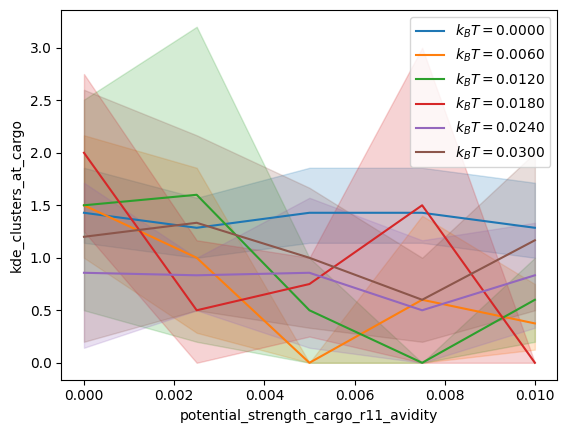

,Unnamed: 0,kde_clusters,kde_clusters_at_cargo,graph_clusters,graph_clusters_at_cargo,potential_strength_r11_r11,potential_strength_cargo_r11,potential_strength_cargo_r11_avidity,kb_temperature_r11,interaction_relative_neighbour_distance,iteration,output_path
587,587,3.0,0.0,168,168,0.005,0.0025,0.0075,0.018,2.0,45000,out/autophagy/explore_parameter_space_2_00014045
649,649,6.0,1.0,163,163,0.005,0.0025,0.0050,0.030,2.0,45000,out/autophagy/explore_parameter_space_2_00013816
657,657,9.0,1.0,158,158,0.005,0.0025,0.0025,0.024,2.0,45000,out/autophagy/explore_parameter_space_2_00013569
813,813,8.0,1.0,165,165,0.005,0.0025,0.0050,0.018,2.0,45000,out/autophagy/explore_parameter_space_2_00013802
840,840,11.0,0.0,159,159,0.005,0.0025,0.0075,0.012,2.0,45000,out/autophagy/explore_parameter_space_2_00014035
...,...,...,...,...,...,...,...,...,...,...,...,...
29250,29250,5.0,0.0,79,79,0.005,0.0025,0.0050,0.006,2.0,45000,out/autophagy/explore_parameter_space_2_00013789
29303,29303,5.0,1.0,153,153,0.005,0.0025,0.0100,0.030,2.0,45000,out/autophagy/explore_parameter_space_2_00014303
29737,29737,10.0,1.0,80,80,0.005,0.0025,0.0100,0.006,2.0,45000,out/autophagy/explore_parameter_space_2_00014268
29762,29762,7.0,2.0,22,22,0.005,0.0025,0.0000,0.000,2.0,45000,out/autophagy/explore_parameter_space_2_00013300


In [5]:
fig, ax = plt.subplots()

df_filtered = df[df["potential_strength_cargo_r11"]==values_potential_strength_cargo_r11[1]]
df_filtered = df_filtered[df_filtered["potential_strength_r11_r11"]==values_potential_strength_r11_r11[2]]
df_filtered = df_filtered[df_filtered["interaction_relative_neighbour_distance"]==values_interaction_relative_neighbour_distance[2]]
for kb_temp in values_kb_temperature_r11:
    df_now = df_filtered[df_filtered["kb_temperature_r11"]==kb_temp]

    sb.lineplot(x="potential_strength_cargo_r11_avidity", y="kde_clusters_at_cargo", data=df_now, ax=ax, label=f"$k_BT={kb_temp:5.4f}$")
ax.legend()
plt.show(fig)
df_filtered

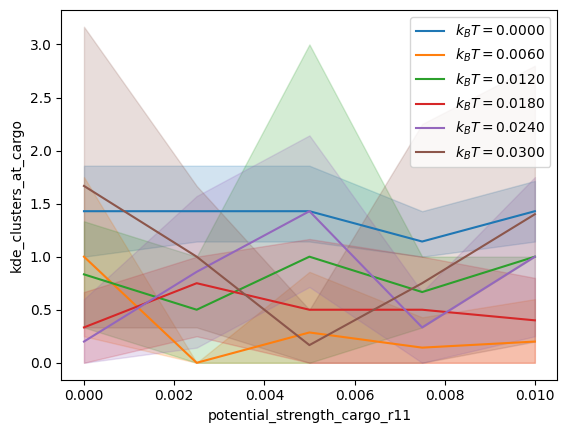

In [6]:
fig, ax = plt.subplots()

df_filtered = df[df["potential_strength_cargo_r11_avidity"]==values_potential_strength_cargo_r11_avidity[2]]
df_filtered = df_filtered[df_filtered["potential_strength_r11_r11"]==values_potential_strength_r11_r11[2]]
df_filtered = df_filtered[df_filtered["interaction_relative_neighbour_distance"]==values_interaction_relative_neighbour_distance[2]]
for kb_temp in values_kb_temperature_r11:
    df_now = df_filtered[df_filtered["kb_temperature_r11"]==kb_temp]

    sb.lineplot(x="potential_strength_cargo_r11", y="kde_clusters_at_cargo", data=df_now, ax=ax, label=f"$k_BT={kb_temp:5.4f}$")
ax.legend()
plt.show(fig)

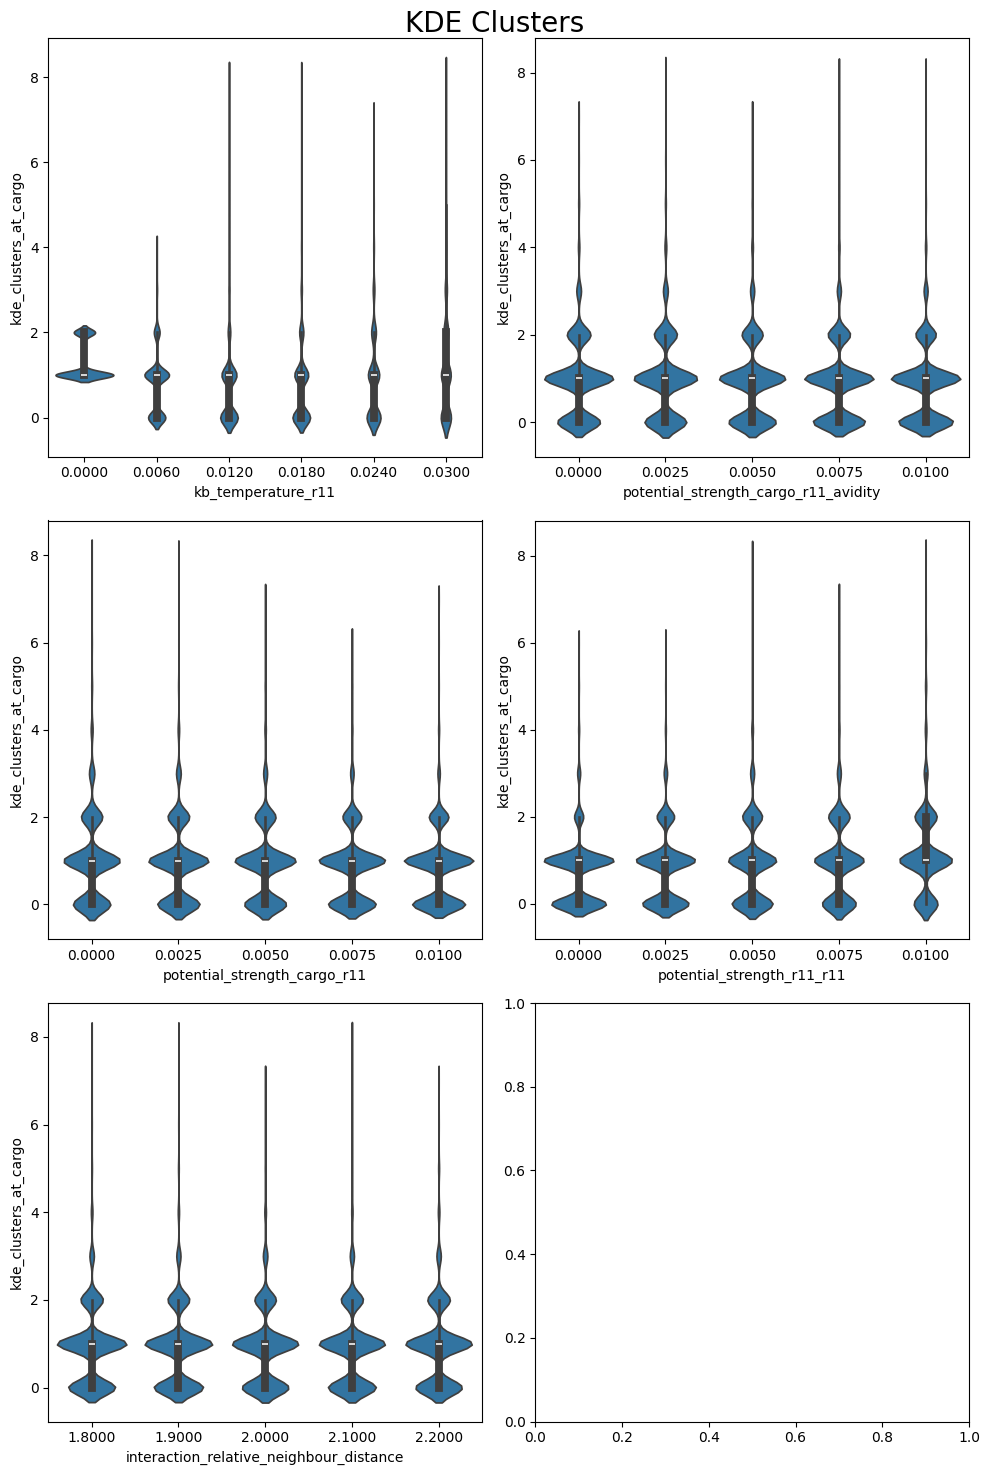

In [7]:
fig, ax = plt.subplots(3, 2, figsize=(10, 15))

fig.suptitle("KDE Clusters", fontsize=20)
sb.violinplot(x="kb_temperature_r11", y="kde_clusters_at_cargo", data=df, formatter=lambda x: f"{x:05.4f}", ax=ax[0,0])
sb.violinplot(x="potential_strength_cargo_r11_avidity", y="kde_clusters_at_cargo", data=df, formatter=lambda x: f"{x:05.4f}", ax=ax[0,1])
sb.violinplot(x="potential_strength_cargo_r11", y="kde_clusters_at_cargo", data=df, formatter=lambda x: f"{x:05.4f}", ax=ax[1,0])
sb.violinplot(x="potential_strength_r11_r11", y="kde_clusters_at_cargo", data=df, formatter=lambda x: f"{x:05.4f}", ax=ax[1,1])
sb.violinplot(x="interaction_relative_neighbour_distance", y="kde_clusters_at_cargo", data=df, formatter=lambda x: f"{x:05.4f}", ax=ax[2,0])
fig.tight_layout()
plt.show()

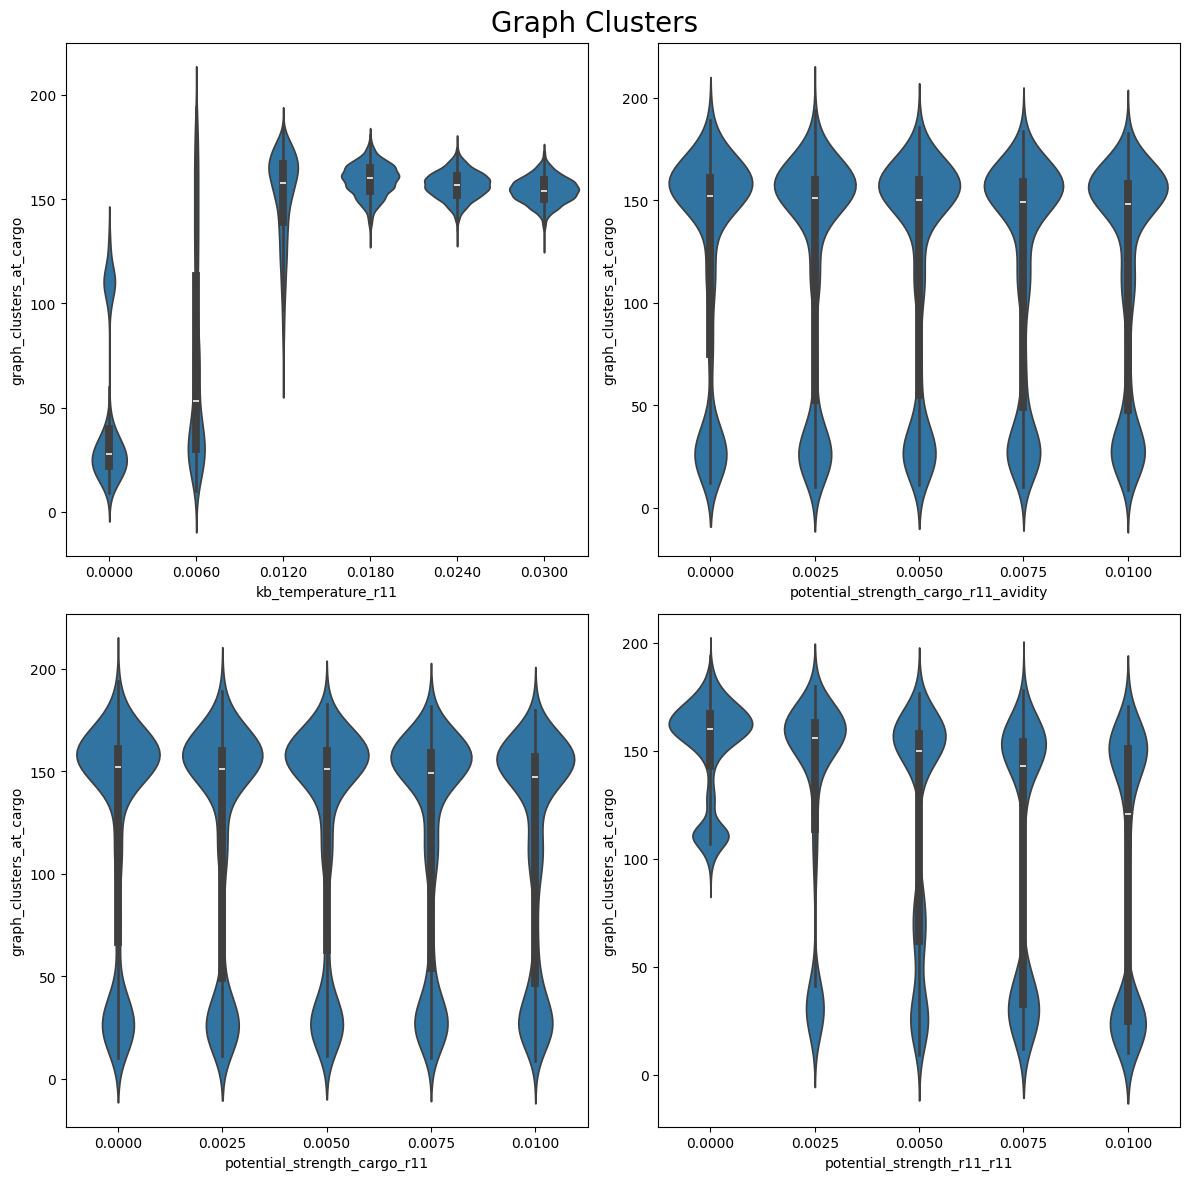

In [11]:
import matplotlib.pyplot as plt
import seaborn as sb
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

fig.suptitle("Graph Clusters", fontsize=20)
sb.violinplot(x="kb_temperature_r11", y="graph_clusters_at_cargo", data=df, formatter=lambda x: f"{x:05.4f}", ax=ax[0,0])
sb.violinplot(x="potential_strength_cargo_r11_avidity", y="graph_clusters_at_cargo", data=df, formatter=lambda x: f"{x:05.4f}", ax=ax[0,1])
sb.violinplot(x="potential_strength_cargo_r11", y="graph_clusters_at_cargo", data=df, formatter=lambda x: f"{x:05.4f}", ax=ax[1,0])
sb.violinplot(x="potential_strength_r11_r11", y="graph_clusters_at_cargo", data=df, formatter=lambda x: f"{x:05.4f}", ax=ax[1,1])
fig.tight_layout()
plt.show()

In [10]:
output_path = cra.get_last_output_path()
# output_path = Path("out/autophagy/2023-12-12-T10-33-01")
max_iter = max(cra.get_all_iterations(output_path))

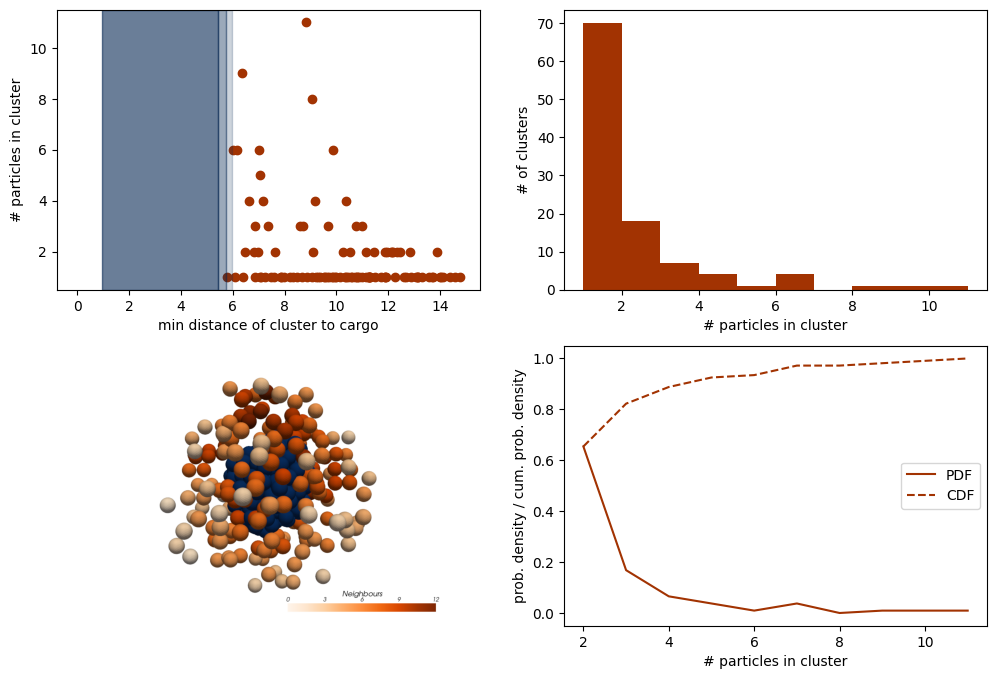

In [11]:
fig = cra.save_cluster_information_plots(output_path, max_iter, connection_distance=2.5, overwrite=True)

6


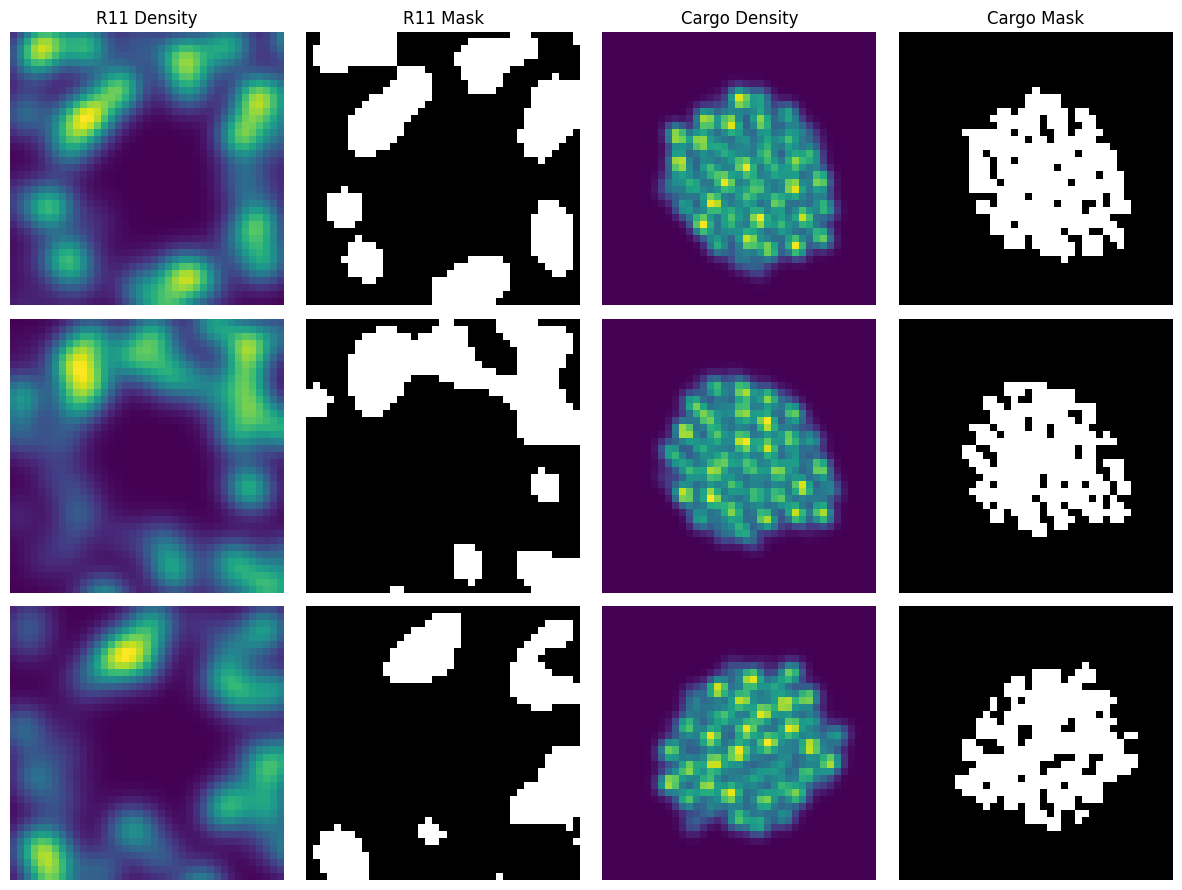

In [12]:
discretization_factor = 0.5
bw_method = 0.2
threshold = 0.4

fig = cra.save_kernel_density(
    output_path,
    max_iter,
    overwrite=True,
    threshold=threshold,
    discretization_factor=discretization_factor,
    bw_method=bw_method
)

kde_clrs = cra.get_clusters_kde(
    output_path,
    max_iter,
    threshold=threshold,
    discretization_factor=discretization_factor,
    bw_method=bw_method
)

kde_clusters_at_cargo = len(kde_clrs.clusters_at_cargo(relative_radial_distance=0.5))
print(kde_clusters_at_cargo)

In [13]:
fig = cra.plot_cluster_distribution(output_path, max_iter, discretization_factor, bw_method)

TypeError: get_clusters_kde() takes from 2 to 3 positional arguments but 4 were given

In [ ]:
# cra.save_all_kernel_density(output_path, threshold=0.6, overwrite=True, bw_method=0.4, discretization_factor=0.5)
# 
# bashcmd = f"ffmpeg -v quiet -stats -y -r 30 -f image2 -pattern_type glob -i '{output_path}/kernel_density/*.png' -c:v h264 -pix_fmt yuv420p -strict -2 {output_path}/kernel_density_movie.mp4"
# os.system(bashcmd)